In [1]:
import os
from datetime import datetime
import functools

import numpy as np
import matplotlib.pyplot as plt
import numba

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from astropy import units as u, constants as const

const_h = const.h.cgs.value
const_c = const.c.cgs.value
const_kb = const.k_B.cgs.value

In [182]:
# Create a system you want to emulate

@numba.njit
def P_cygni(grid, nu, vel, amp):
    
    wave = const_c / nu
    wave_grid = const_c/grid
    absorption = np.ones(len(grid))
    wave_m = wave*vel/const_c

    absorption[np.where((wave_grid < wave) & (wave_grid > wave-wave_m))] = 0.0
    absorption /= absorption.sum()
    absorption -= 0.5/len(absorption)
    
    emission = (np.exp(-((wave - wave_grid)**2)/(2*(wave_m/3)**2)))
    emission /= emission.sum()

    profile = emission + absorption

    return profile

@numba.njit
def spectrum(nu, T, amp1, amp2, amp3, vel1, vel2, vel3):
    
    BB =  2 * const_h * nu**3 / const_c**2 * 1 / (np.exp((nu * const_h) / (const_kb * T)) - 1)

    BB += P_cygni(nu, 2e14, vel1, 1e-1)*amp1
    BB += P_cygni(nu, 1e14, vel2, 1e-1)*amp2
    BB += P_cygni(nu, 5e13, vel3, 1e-1)*amp3
    
    return BB

@numba.njit(parallel=True)
def gen_spectra(parameters):
    
    spectra = np.empty((len(parameters), len(hz_grid)))
    for i in numba.prange(len(parameters)):
        T, amp1, amp2, amp3, vel1, vel2, vel3 = parameters[i]
        spectra[i] = spectrum(hz_grid, T, amp1, amp2, amp3, vel1, vel2, vel3)
    return spectra


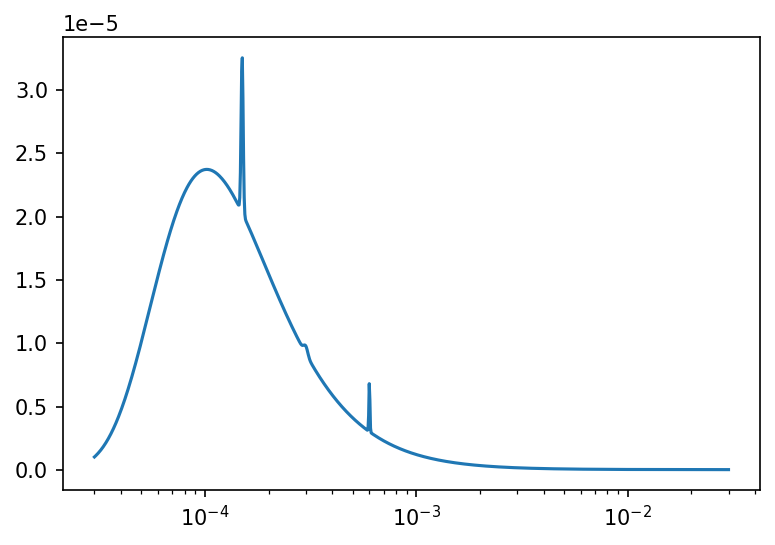

In [183]:
%matplotlib inline

hz_grid = np.logspace(12, 15, 1000)
spec = spectrum(hz_grid, 5000.0, 5e-5, 5e-6, 8e-6, 1e9, 2e9, 5e8)

plt.figure(dpi=150)

plt.plot(const_c/hz_grid, spec)

plt.xscale('log')

In [55]:
# Generate some random samples

N = 50000
hz_grid = np.logspace(12, 15, 1000)
temperatures = np.random.random(N) * (10000 - 2000) + 2000
amp1s = 10**(np.random.random(N) * (-4 - -6) + -6)
amp2s = 10**(np.random.random(N) * (-4 - -6) + -6)
amp3s = 10**(np.random.random(N) * (-4 - -6) + -6)

vel1s = 10**(np.random.random(N) * (10 - 8) + 8)
vel2s = 10**(np.random.random(N) * (10 - 8) + 8)
vel3s = 10**(np.random.random(N) * (10 - 8) + 8)

params = np.vstack((temperatures, amp1s, amp2s, amp3s, vel1s, vel2s, vel3s)).T

spectra = gen_spectra(params)

X = params
Y = spectra

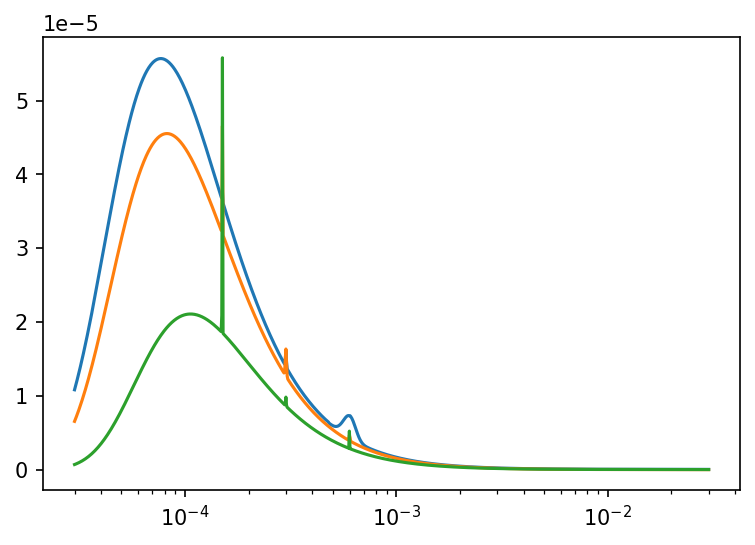

In [63]:
%matplotlib inline

plt.figure(dpi=150)

plt.plot(const_c/hz_grid, spectra[0])
plt.plot(const_c/hz_grid, spectra[1])
plt.plot(const_c/hz_grid, spectra[2])

plt.xscale('log')

In [57]:
# Preprocess the data

X_nn = X.copy()
X_nn[:, 1:] = np.log10(X_nn[:, 1:])

X_min = X_nn.min(axis=0)
X_max = X_nn.max(axis=0)

X_nn = (X_nn - X_min) / (X_max - X_min)

Y_nn = np.log10(Y)

Y_min = Y_nn.min(axis=0)
Y_max = Y_nn.max(axis=0)

Y_nn = (Y_nn - Y_min) / (Y_max - Y_min)



In [ ]:
# Split the data into training and validation sets

(X_train, 
 X_val,
 Y_train,
 Y_val) = train_test_split(X_nn, Y_nn, train_size=0.7, random_state=42, shuffle=True)

In [58]:
# Build the model

model = Sequential()
model.add(Dense(64, input_dim=X_nn.shape[1], activation='softplus', kernel_initializer='VarianceScaling', ))
model.add(Dense(64, activation='softplus', kernel_initializer='VarianceScaling', ))
model.add(Dense(Y_nn.shape[1], activation='softplus', kernel_initializer='VarianceScaling',))

model.compile(loss='mean_squared_error', optimizer='nadam')
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 64)                512       
_________________________________________________________________
dense_55 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_56 (Dense)             (None, 1000)              65000     
Total params: 69,672
Trainable params: 69,672
Non-trainable params: 0
_________________________________________________________________
None


2023-03-23 00:39:42.118144: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2023-03-23 00:39:42.118420: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2023-03-23 00:39:42.118436: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED
2023-03-23 00:39:42.118457: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER
2023-03-23 00:39:42.585049: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2023-03-23 00:39:42.585198: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc

In [49]:
# Train the model

def train(model, X_train, Y_train, X_val, Y_val, **kwargs):
    
    X_train = tf.convert_to_tensor(X_train)
    Y_train = tf.convert_to_tensor(Y_train)
    Train = (X_train, Y_train)

    X_val = tf.convert_to_tensor(X_val)
    Y_val = tf.convert_to_tensor(Y_val)
    Val = (X_val, Y_val)
    
    cur_date_str = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    logdir="logs/scalars/" + cur_date_str
    tensorboard_callback = TensorBoard(log_dir=logdir)
    checkpoints_dir = os.path.join('checkpoints', cur_date_str)
    os.makedirs(checkpoints_dir, exist_ok=True)
    checkpointer_best = ModelCheckpoint(monitor='val_loss', 
                                        filepath=os.path.join(checkpoints_dir, 'grid_weights_best.h5'), 
                                        save_best_only=True, save_weights_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   min_delta=0, patience=500, 
                                   verbose=0, mode='auto', baseline=None, 
                                   restore_best_weights=True)
    fit_kwargs = dict(validation_data=Val, 
                  epochs=400000, batch_size=128,
                  callbacks=[checkpointer_best, tensorboard_callback, early_stopping], 
                  verbose=0)
    fit_kwargs.update(kwargs)

    model.fit(*Train, **fit_kwargs)

In [ ]:
train(model, X_train, Y_train, X_val, Y_val)

In [187]:
#Make some test data

N_test = 10
hz_grid = np.logspace(12, 15, 1000)
temperatures_test = np.random.random(N_test) * (10000 - 2000) + 2000
amp1s_test = 10**(np.random.random(N_test) * (-4 - -6) + -6)
amp2s_test = 10**(np.random.random(N_test) * (-4 - -6) + -6)
amp3s_test = 10**(np.random.random(N_test) * (-4 - -6) + -6)

vel1s_test = 10**(np.random.random(N_test) * (10 - 8) + 8)
vel2s_test = 10**(np.random.random(N_test) * (10 - 8) + 8)
vel3s_test = 10**(np.random.random(N_test) * (10 - 8) + 8)

params_test = np.vstack((temperatures_test, 
                         amp1s_test, amp2s_test, 
                         amp3s_test, vel1s_test, 
                         vel2s_test, vel3s_test)).T


spectra_test = gen_spectra(params_test)
X_test = params_test
Y_test = spectra_test

# Preprocess

X_nn_test = X_test.copy()
X_nn_test[:, 1:] = np.log10(X_nn_test[:, 1:])

X_nn_test = (X_nn_test - X_min) / (X_max - X_min)


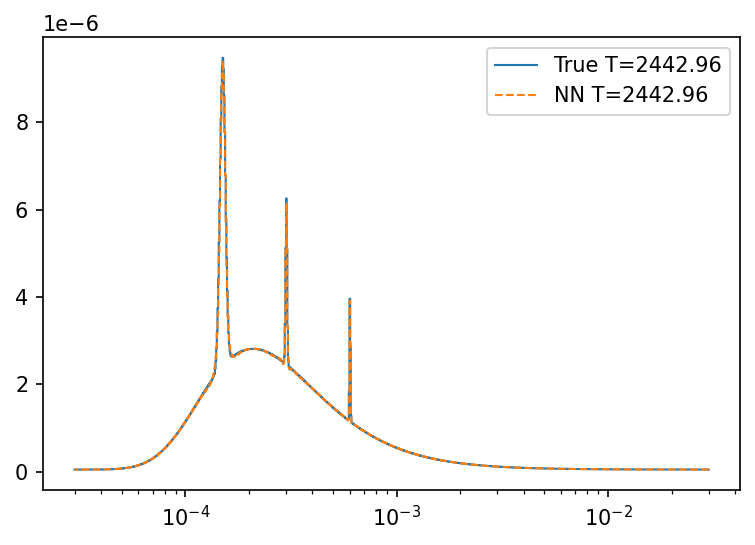

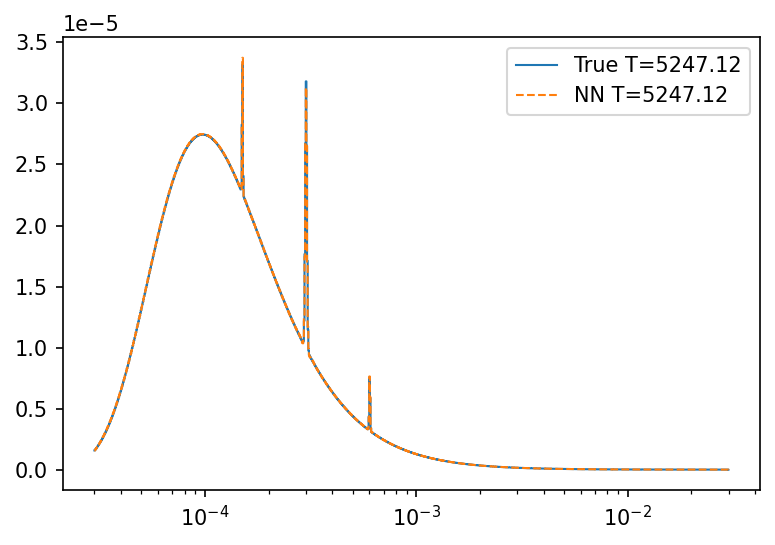

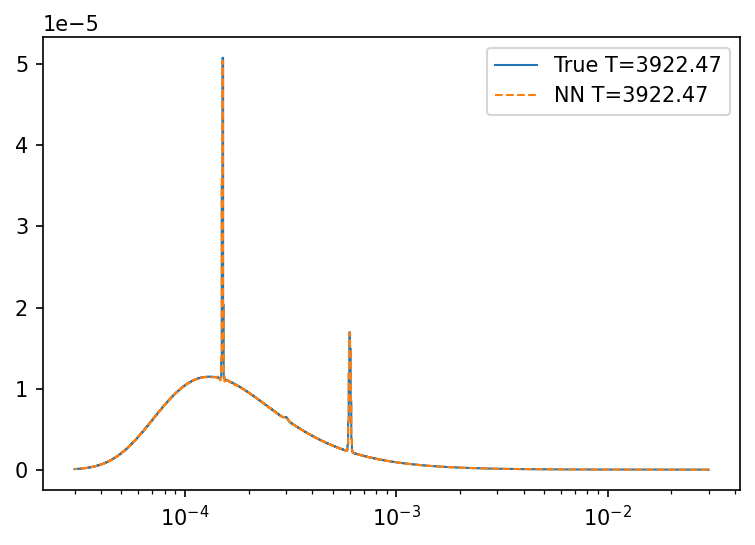

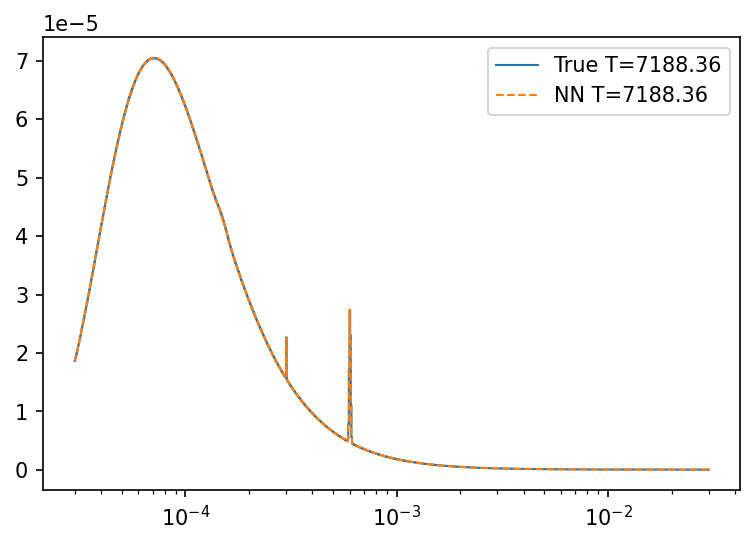

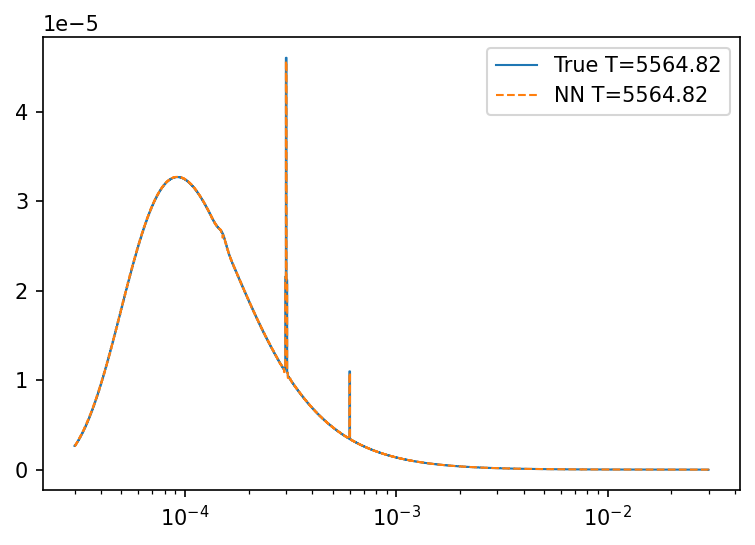

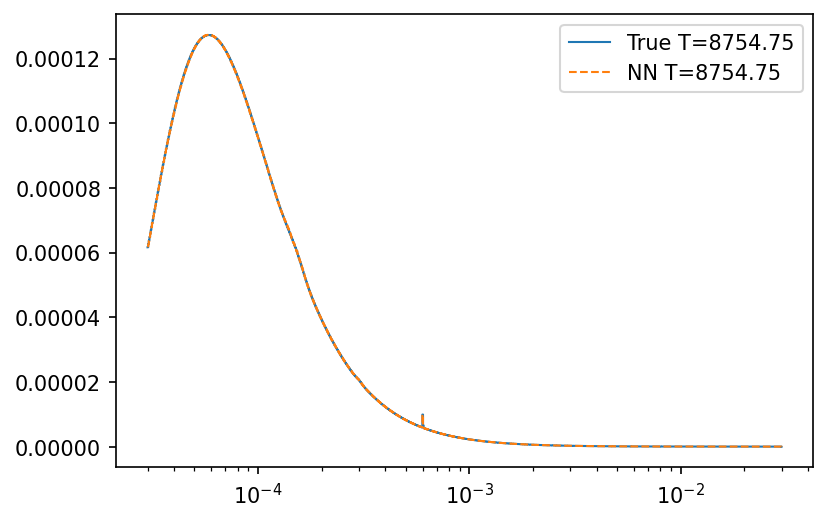

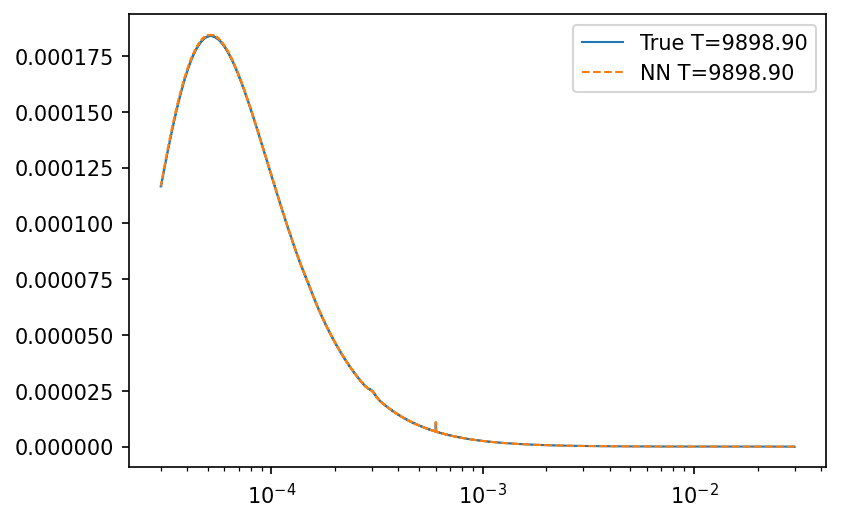

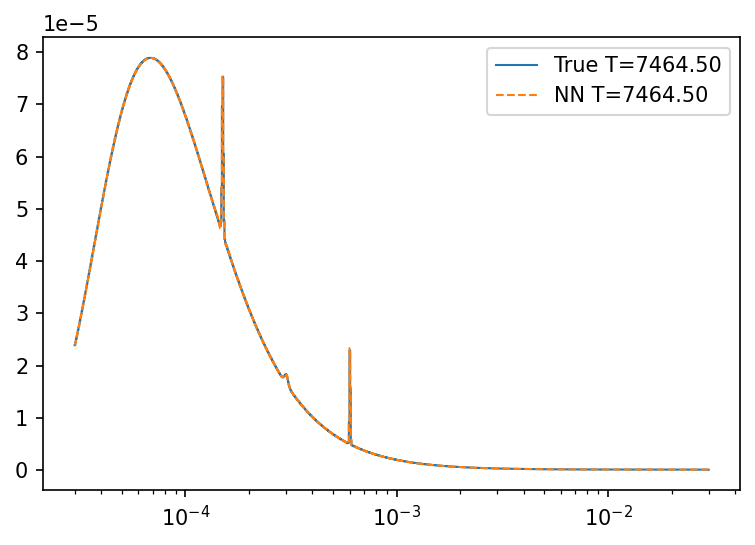

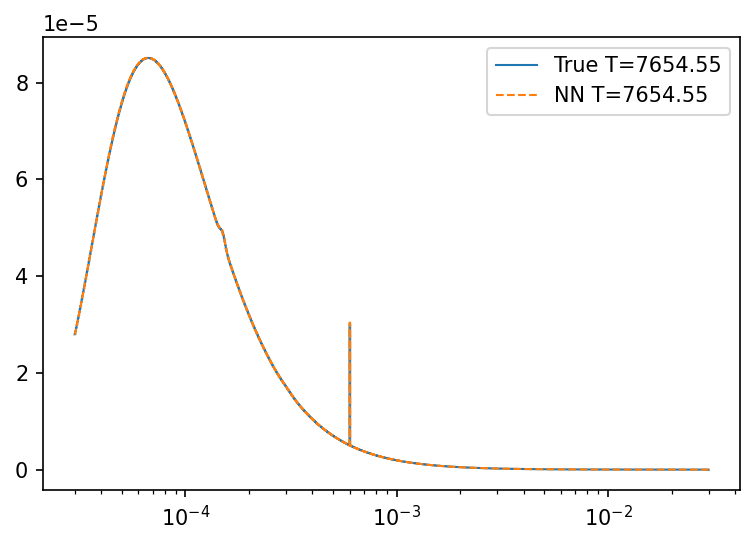

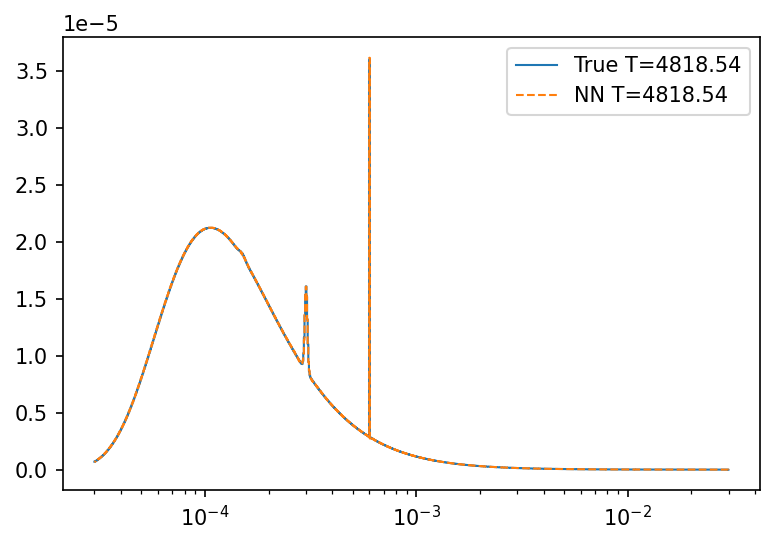

In [188]:
# Evaluate the model
%matplotlib inline

Y_nn_test = model(X_nn_test, training=False) 
Y_emu_test = 10**(Y_nn_test * (Y_max - Y_min) + Y_min) # Post Process

for i in range(N_test):
    temp = params_test[i, 0]
    plt.figure(dpi=150)
    plt.step(const_c/hz_grid, Y_test[i], label=f'True T={temp:.2f}', lw=1)
    plt.step(const_c/hz_grid, Y_emu_test[i], label=f'NN T={temp:.2f}', ls='--', lw=1)

    plt.xscale('log')
    plt.legend()

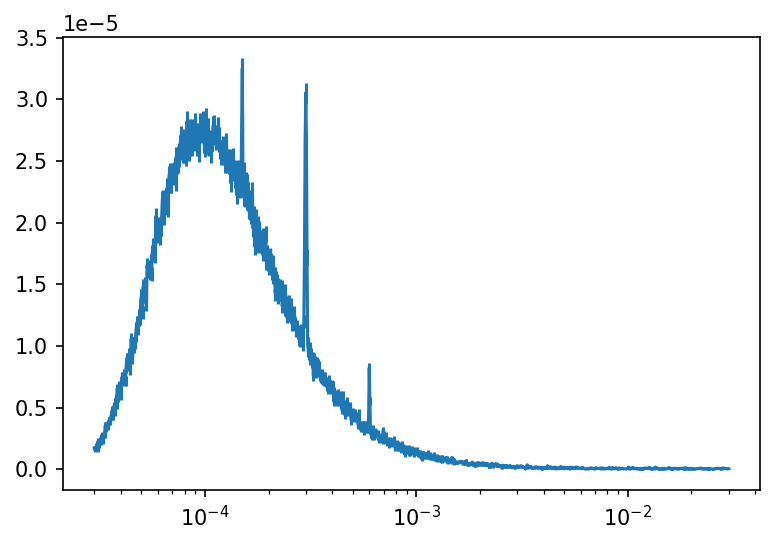

In [191]:
%matplotlib inline

sample_spectrum = spectra_test[1].copy()
sample_spectrum_int = sample_spectrum.sum()
sample_spectrum_norm = sample_spectrum / sample_spectrum_int

photons = np.random.random((len(hz_grid), 300000))
counts = np.array([np.sum(photons[i] < sample_spectrum_norm[i]) for i in range(len(hz_grid))])
counts_int = counts.sum()

sample_spectrum = counts / counts_int * sample_spectrum_int
sample_spectrum_err = np.sqrt(counts) / counts_int * sample_spectrum_int
sample_spectrum_err[sample_spectrum_err == 0] = 1 / counts_int * sample_spectrum_int

plt.figure(dpi=150)

plt.errorbar(const_c/hz_grid, sample_spectrum, yerr=sample_spectrum_err)

plt.xscale('log')

In [192]:
import ultranest

def prior_transform(cube):
    
    # Transform random uniforms into our parameters
    cube = cube.copy()
    
    cube[:, 0] = cube[:, 0] * (10000 - 2000) + 2000
    
    cube[:, 1] = 10**(cube[:, 1] * (-4 - -6) + -6)
    cube[:, 2] = 10**(cube[:, 2] * (-4 - -6) + -6)
    cube[:, 3] = 10**(cube[:, 3] * (-4 - -6) + -6)
    
    cube[:, 4] = 10**(cube[:, 4] * (10 - 8) + 8)
    cube[:, 5] = 10**(cube[:, 5] * (10 - 8) + 8)
    cube[:, 6] = 10**(cube[:, 6] * (10 - 8) + 8)
    
    return cube
    
def likelihood(parameters):
    
    # Preprocess the data
    parameters_nn = parameters.copy()
    parameters_nn[:, 1:] = np.log10(parameters_nn[:, 1:])
    parameters_nn = (parameters_nn - X_min[None, :]) / (X_max - X_min)[None, :]
    
    #evaluate the model
    spectra_nn = model(parameters_nn, training=False).numpy()
    
    # Postprocess the spectra
    spectra = 10**(spectra_nn * (Y_max - Y_min)[None, :] + Y_min[None, :])
    
    # Compute the likelihood
    log_like = -0.5*np.sum(
        (spectra - sample_spectrum[None, :])**2/(sample_spectrum_err[None, :]**2),
        axis=1
    )
    
    return log_like

param_names = ['Temperature', 'A1', 'A2', 'A3', 'V1', 'V2', 'V3']

sampler = ultranest.ReactiveNestedSampler(param_names, 
                                          likelihood, 
                                          prior_transform, 
                                          vectorized=True, 
                                          ndraw_min=4096)
sampler_result = sampler.run()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-6e+02  .17 [-564.7143..-564.7142]*| it/evals=12600/94665 eff=13.3666% N=400        00 0 
[ultranest] Likelihood function evaluations: 94665
[ultranest]   logZ = -591.5 +- 0.159
[ultranest] Effective samples strategy satisfied (ESS = 2723.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.24 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.


In [193]:
sampler.print_results()


logZ = -591.492 +- 0.183
  single instance: logZ = -591.492 +- 0.244
  bootstrapped   : logZ = -591.533 +- 0.183
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    Temperature         : 5231.1│ ▁ ▁▁▁▁▁▁▁▂▂▃▄▄▆▇▇▇▇▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁ ▁ │5257.2    5243.5 +- 2.9
    A1                  : 0.0000083│ ▁▁▁▁▁▁▁▁▂▂▃▄▄▅▆▆▇▆▇▆▆▅▄▄▃▂▁▁▁▁▁▁▁▁▁ ▁ │0.0000184    0.0000131 +- 0.0000013
    A2                  : 0.0000587│ ▁   ▁▁▁▁▁▁▁▂▂▃▄▅▅▆▇▇▆▆▅▄▃▂▁▁▁▁▁▁▁▁▁ ▁ │0.0000746    0.0000669 +- 0.0000016
    A3                  : 0.00000489│ ▁▁▁▁▁▁▁▁▂▂▃▄▄▅▆▇▇▇▇▇▅▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁ │0.00001016    0.00000736 +- 0.00000063
    V1                  : 204064115│ ▁▁▁▁▁▁▁▁▂▃▃▄▆▇▇▇▇▆▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁   ▁ │584822563    366709906 +- 41323130
    V2                  : 714677079│ ▁▁▁▁▁▁▁▁▁▁▂▃▅▅▆▇▇▇▇▆▆▅▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁ │909940474    808867760 +- 22256787
    V3                  : 230183371│ ▁▁▁▁▁▁▁▂▃▄▅▆▇▇▇▆▆▅▄▄▃▂▁▁▁▁▁▁▁▁▁▁    ▁ │578817075    369000907 +- 36636784



In [197]:
print('{:<12} | {:^8} | {:^8} | {:^8}'.format('Name', 'Mean', 'Std', 'True'))
for name, mean, std, true in zip(
    param_names, 
    sampler.results['posterior']['mean'], 
    sampler.results['posterior']['stdev'],
    params_test[1]
):
    print(f'{name:<12} | {mean:^7.2e} | {std:^7.2e} | {true:^7.2e}')

Name         |   Mean   |   Std    |   True  
Temperature  | 5.24e+03 | 2.89e+00 | 5.25e+03
A1           | 1.31e-05 | 1.26e-06 | 1.80e-05
A2           | 6.69e-05 | 1.63e-06 | 7.51e-05
A3           | 7.36e-06 | 6.34e-07 | 8.53e-06
V1           | 3.67e+08 | 4.13e+07 | 3.92e+08
V2           | 8.09e+08 | 2.23e+07 | 8.51e+08
V3           | 3.69e+08 | 3.66e+07 | 4.59e+08


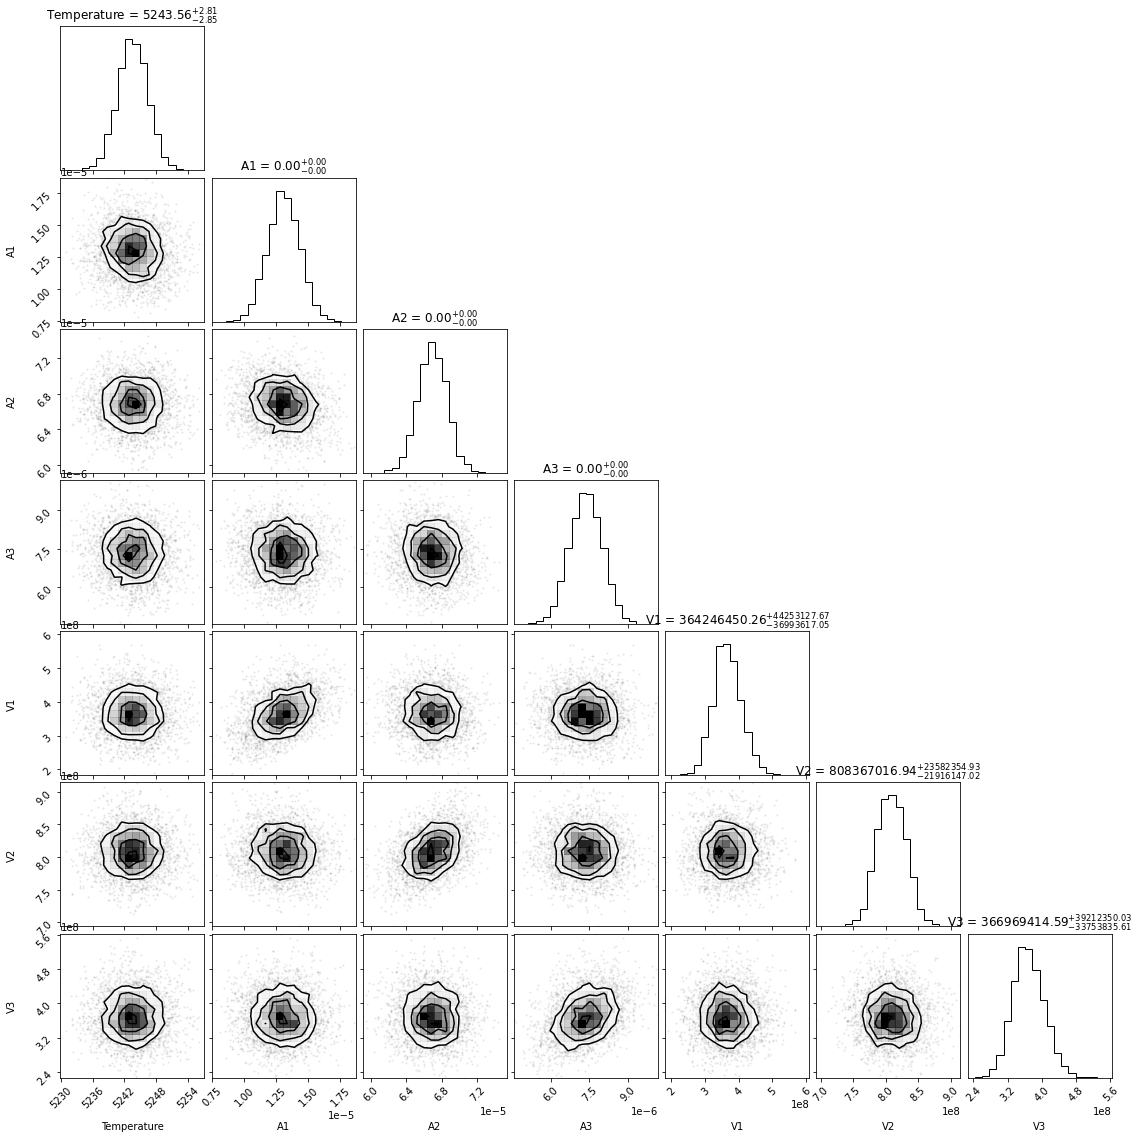

In [195]:
%matplotlib inline

sampler.plot_corner()

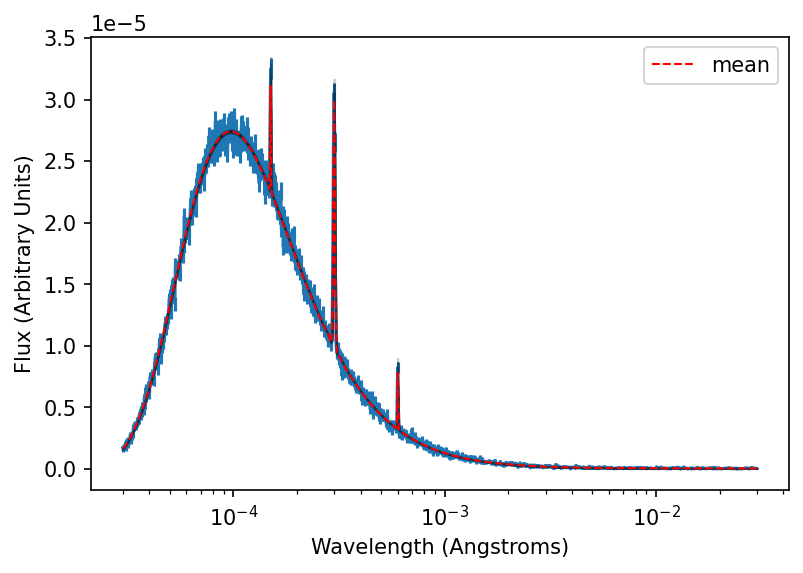

In [196]:
%matplotlib inline
from ultranest.plot import PredictionBand

plt.figure(dpi=150)

plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (Arbitrary Units)')

band = PredictionBand(const_c/hz_grid)
plt.errorbar(const_c/hz_grid, sample_spectrum, yerr=sample_spectrum_err, zorder=-10)

samples = sampler.results['samples']#[:40]

# Preprocess the samples
parameters_nn = samples.copy()
parameters_nn[:, 1:] = np.log10(parameters_nn[:, 1:])
parameters_nn = (parameters_nn - X_min[None, :]) / (X_max - X_min)[None, :]

#evaluate the model
spectra_nn = model(parameters_nn, training=False).numpy()

# Postprocess the spectra
spectra_samples = 10**(spectra_nn * (Y_max - Y_min)[None, :] + Y_min[None, :])

# Plot the prediction bands
for spectrum in spectra_samples:
    band.add(spectrum)

band.shade(color='k', alpha=0.2, q=0.995/2)
band.shade(color='k', alpha=0.2, q=0.97/2)
band.shade(color='k', alpha=0.2)

band.line(color='r', label='mean', ls='--', lw=1)

plt.legend()
plt.xscale('log');